<a href="https://colab.research.google.com/github/Ganeshkumar-1358/batch-20_1358/blob/main/pds_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Big dataset created with shape: (10000, 5)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/tmp/ipython-input-2671417291.py:117: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crops, y=probs, palette="viridis")


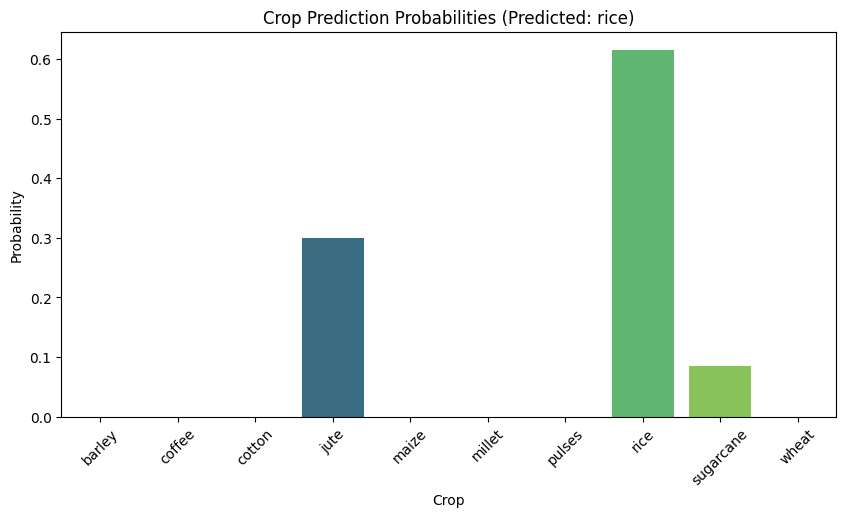

🌱 Predicted Crop: rice
📌 Reason: Selected because its ideal conditions closely match -> Temperature=26°C, Humidity=82%, pH=6.5, Rainfall=220 mm


'rice'

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# -------------------------------
# STEP 1: Create Big Dataset
# -------------------------------

crops = ["rice", "wheat", "maize", "cotton", "sugarcane",
         "coffee", "barley", "millet", "pulses", "jute"]

def generate_crop_data(crop, n=1000):
    if crop == "rice":
        temp = np.random.uniform(20, 35, n)
        humidity = np.random.uniform(70, 90, n)
        ph = np.random.uniform(5.5, 7.5, n)
        rainfall = np.random.uniform(150, 300, n)
    elif crop == "wheat":
        temp = np.random.uniform(10, 25, n)
        humidity = np.random.uniform(50, 70, n)
        ph = np.random.uniform(6.0, 7.5, n)
        rainfall = np.random.uniform(50, 120, n)
    elif crop == "maize":
        temp = np.random.uniform(18, 27, n)
        humidity = np.random.uniform(60, 80, n)
        ph = np.random.uniform(5.8, 7.0, n)
        rainfall = np.random.uniform(80, 200, n)
    elif crop == "cotton":
        temp = np.random.uniform(20, 35, n)
        humidity = np.random.uniform(60, 75, n)
        ph = np.random.uniform(5.5, 7.0, n)
        rainfall = np.random.uniform(50, 150, n)
    elif crop == "sugarcane":
        temp = np.random.uniform(20, 38, n)
        humidity = np.random.uniform(70, 85, n)
        ph = np.random.uniform(6.0, 7.5, n)
        rainfall = np.random.uniform(100, 250, n)
    elif crop == "coffee":
        temp = np.random.uniform(15, 25, n)
        humidity = np.random.uniform(65, 85, n)
        ph = np.random.uniform(6.0, 6.8, n)
        rainfall = np.random.uniform(150, 250, n)
    elif crop == "barley":
        temp = np.random.uniform(12, 25, n)
        humidity = np.random.uniform(45, 65, n)
        ph = np.random.uniform(6.0, 7.5, n)
        rainfall = np.random.uniform(40, 100, n)
    elif crop == "millet":
        temp = np.random.uniform(25, 35, n)
        humidity = np.random.uniform(40, 60, n)
        ph = np.random.uniform(5.0, 7.0, n)
        rainfall = np.random.uniform(30, 80, n)
    elif crop == "pulses":
        temp = np.random.uniform(20, 30, n)
        humidity = np.random.uniform(50, 70, n)
        ph = np.random.uniform(6.0, 7.5, n)
        rainfall = np.random.uniform(50, 100, n)
    elif crop == "jute":
        temp = np.random.uniform(24, 35, n)
        humidity = np.random.uniform(70, 90, n)
        ph = np.random.uniform(5.5, 7.0, n)
        rainfall = np.random.uniform(150, 250, n)

    return pd.DataFrame({
        "Temperature": temp,
        "Humidity": humidity,
        "pH_Value": ph,
        "Rainfall": rainfall,
        "Crop": crop
    })

# Generate big dataset
dataframes = [generate_crop_data(crop, 1000) for crop in crops]
big_df = pd.concat(dataframes, ignore_index=True)
big_df.to_csv("Big_Crop_Dataset.csv", index=False)

print("✅ Big dataset created with shape:", big_df.shape)

# -------------------------------
# STEP 2: Train Model
# -------------------------------

X = big_df[['Temperature','Humidity','pH_Value','Rainfall']]
y = big_df['Crop']

# Encode crop labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train RandomForest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# -------------------------------
# STEP 3: Prediction Function
# -------------------------------

def predict_crop_with_reason(temp, hum, ph, rain):
    features = [[temp, hum, ph, rain]]

    # Prediction probabilities
    probs = rf.predict_proba(features)[0]
    crops = le.inverse_transform(range(len(probs)))

    # Best crop
    best_crop = crops[np.argmax(probs)]

    # Plot probabilities
    plt.figure(figsize=(10,5))
    sns.barplot(x=crops, y=probs, palette="viridis")
    plt.xticks(rotation=45)
    plt.title(f"Crop Prediction Probabilities (Predicted: {best_crop})")
    plt.ylabel("Probability")
    plt.xlabel("Crop")
    plt.show()

    # Explanation
    print(f"🌱 Predicted Crop: {best_crop}")
    print(f"📌 Reason: Selected because its ideal conditions closely match -> "
          f"Temperature={temp}°C, Humidity={hum}%, pH={ph}, Rainfall={rain} mm")

    return best_crop

# -------------------------------
# STEP 4: Example Run
# -------------------------------
predict_crop_with_reason(26, 82, 6.5, 220)  # Example weather input
